# Get organized JGA results

Purpose: quickly examine only the JGA results before deciding to run CheckDST 

Assumption: ran `rename_folder_with_opts.py` on the directory to summarize JGA results on
- This can be done with `python rename_folder_with_opts.py <dir>`, such as the code block below: 

In [72]:
# !python rename_folder_with_opts.py <dir>

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
from pathlib import Path
import pandas as pd
import json
import re 
from pprint import pprint
from loguru import logger
import numpy as np 
from scipy import stats
from collections import defaultdict
import math
from utils import get_test_results_in_train_stats, print_jga_summary


In [75]:
# print_jga_summary("bart_scratch_multiwoz2.3")
# print_jga_summary("bart_muppet_multiwoz2.3")
# print_jga_summary("bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3")
# print_jga_summary("paper_results/bart_scratch_multiwoz2.3")
# print_jga_summary("paper_results/bart_muppet_multiwoz2.3")
# print_jga_summary("paper_results/bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3")


Why is there a difference between the recent runs for fs_False_prompts_True_lr5e-05_bs4_uf1 and what I had previously? 

- Compare opts 
    - there is no difference in the opts that are relevant to training 
    - after comparing previous versions of the multiwoz_dst file, I found that I increased the validation set size to 500 from 300. 
    - Note: this means that the stopping point was different. 

Summarize results
- load all report files for each invariances, get average for multiple runs, and show trend with graph. 

In [76]:
from utils import get_parlai_inv_results, melt_and_format_target_df, plot_cjga_trends

In [77]:
main_dirs = [
    "bart_scratch_multiwoz2.3",
    "bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3",
    "bart_muppet_multiwoz2.3",
    "bart_scratch_multiwoz2.3/granular",
    "bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3/granular",
    "bart_muppet_multiwoz2.3/granular",  
    "gpt2_simpletod_multiwoz2.3",
    "gpt2_soloist_multiwoz2.3", 
    "bart_scratch_sgd_ft_lr5e-6_bs8_uf1_npu4_sd0_2021-11-19_multiwoz2.3"   
]

In [78]:
fn2name = {
    "bart_scratch_multiwoz2.3": "BART-DST",
    "bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3": "PrefineDST",
    "bart_muppet_multiwoz2.3": "MUPPET-DST", 
    "bart_scratch_multiwoz2.3/granular": "BART-DST <1",
    "bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3/granular": "PrefineDST <1",
    "bart_muppet_multiwoz2.3/granular": "MUPPET-DST <1", 
    "gpt2_simpletod_multiwoz2.3": "SimpleTOD",
    "gpt2_soloist_multiwoz2.3": "SOLOIST-GPT2", 
    "bart_scratch_sgd_ft_lr5e-6_bs8_uf1_npu4_sd0_2021-11-19_multiwoz2.3": "SOLOIST" 
}

In [79]:
print_ = False
results = defaultdict(dict) 
for main_dir in main_dirs:
    if print_: 
        print(main_dir) 
    epoch_precision = 0.02 if "granular" in main_dir else 1 

    full_df, few_df = get_parlai_inv_results(main_dir, print_, epoch_precision=epoch_precision)
    results[main_dir] = {
        "full": full_df, 
        "few": few_df 
    }

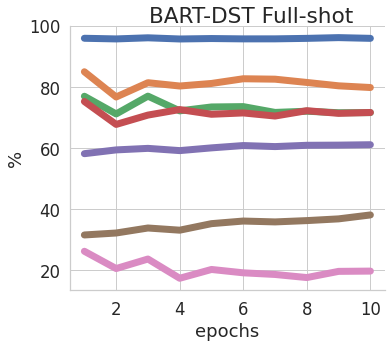

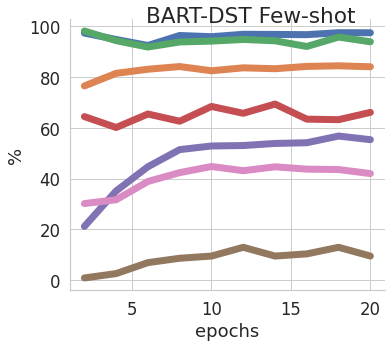

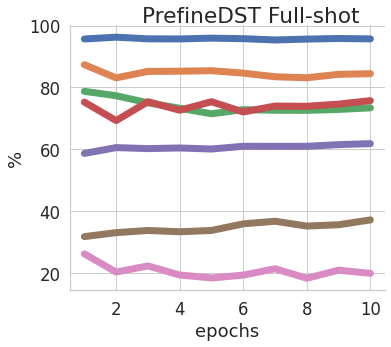

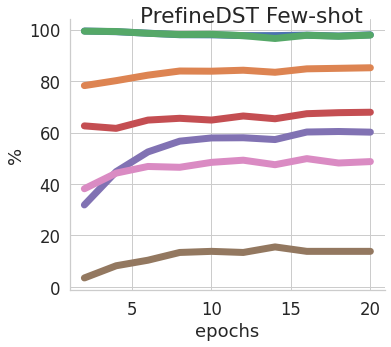

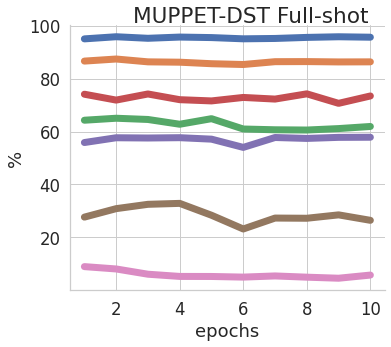

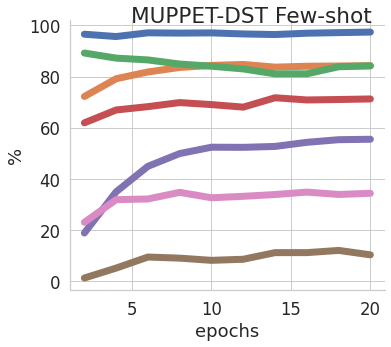

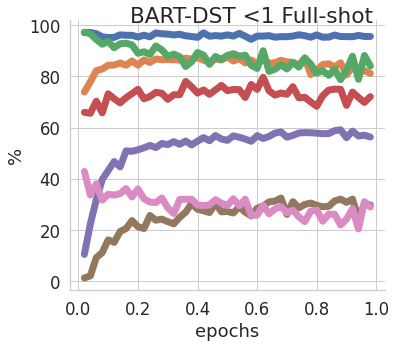

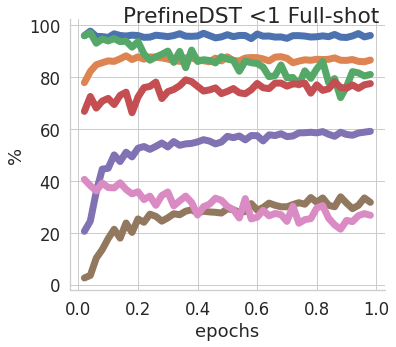

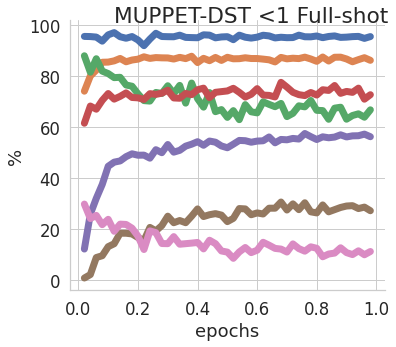

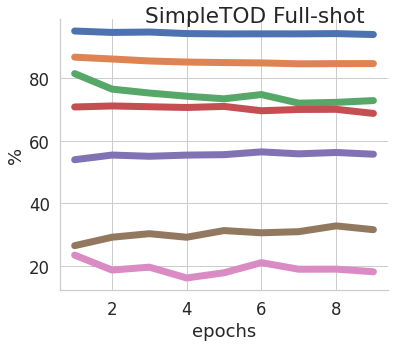

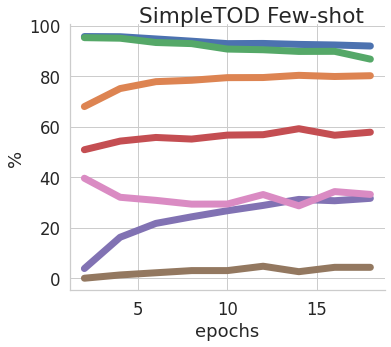

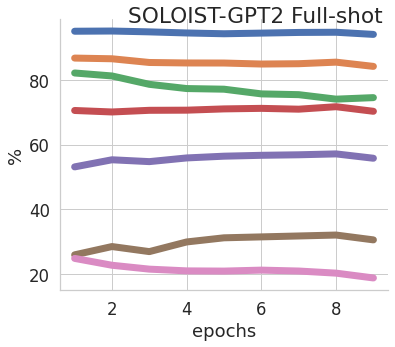

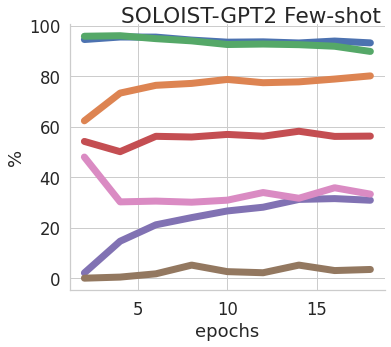

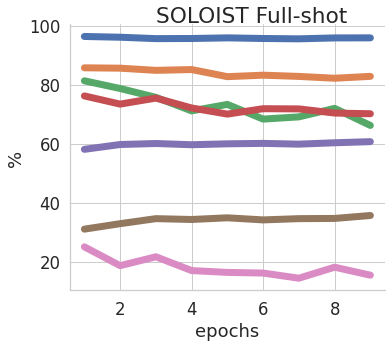

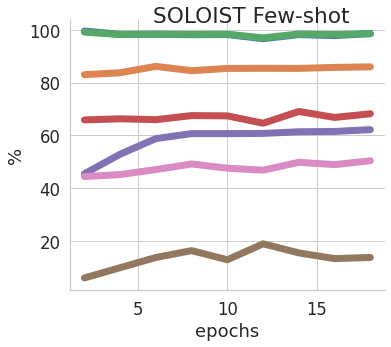

In [80]:
for dir_name,v in results.items(): 
    full_df = v['full']
    few_df = v['few']
    no_band = True 
    # no_band = False 
    if not full_df.empty: 
        full_molten_df = melt_and_format_target_df(full_df)
        plot_cjga_trends(full_molten_df, no_band, title= fn2name.get(dir_name, dir_name) + " Full-shot")

    if not few_df.empty: 
        few_molten_df = melt_and_format_target_df(few_df)
        plot_cjga_trends(few_molten_df, no_band, title=fn2name.get(dir_name, dir_name) + " Few-shot")

In [81]:
dirs_to_combine = ["bart_scratch_multiwoz2.3", "bart_scratch_multiwoz2.3/granular"] 


In [82]:
results["bart_scratch_multiwoz2.3"]["full"].groupby("epochs").agg("median")[custom_target_metrics]

,NoHF Orig,TP cJGA,NoHF Swap,SD cJGA,test_jga,coref_jga,NEI cJGA
epochs,,,,,,,
1,0.958808,0.849370,0.769290,0.752152,0.581525,0.315789,0.262505
2,0.956696,0.766863,0.711411,0.702821,0.593869,0.327169,0.205979
3,0.960339,0.813556,0.769635,0.707699,0.598888,0.338549,0.237136
4,0.956496,0.802741,0.721546,0.725789,0.591563,0.331437,0.174230
5,0.957950,0.811097,0.734260,0.710379,0.600515,0.352774,0.202996
6,0.956841,0.826457,0.735379,0.714713,0.608112,0.361309,0.192039
7,0.956934,0.825076,0.716397,0.704590,0.604721,0.365576,0.186654
8,0.958488,0.814365,0.720368,0.722080,0.608926,0.362731,0.176543
9,0.960952,0.803376,0.715375,0.713340,0.609468,0.368421,0.196776


In [83]:
# results["bart_scratch_multiwoz2.3/granular"]["full"].groupby("epochs").agg("median")
comb_dirs = [
    "bart_scratch_multiwoz2.3",
    "bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3",
    "bart_muppet_multiwoz2.3",

    "bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3/granular",
    "bart_muppet_multiwoz2.3/granular",  
    "gpt2_simpletod_multiwoz2.3",
    "gpt2_soloist_multiwoz2.3", 
    "bart_scratch_sgd_ft_lr5e-6_bs8_uf1_npu4_sd0_2021-11-19_multiwoz2.3"   
]

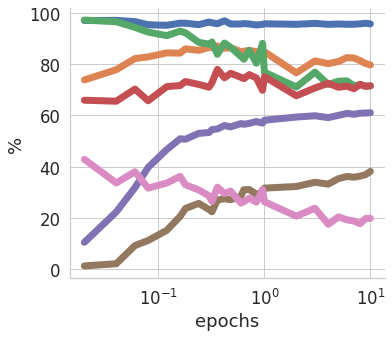

In [84]:
dc = ["bart_scratch_multiwoz2.3"] 
dc += [dc[0] + "/granular"]
combined = pd.concat([melt_and_format_target_df(results[d]['full'], custom_target_metrics) for d in dc]).reset_index()
# combined = combined[(combined["epochs"] >= 1.0) | (combined["epochs"]*50 % 8 ==0 )]
combined = combined[(combined["epochs"] >= 1.0) | (combined["epochs"]% 0.02 ==0) | (combined["epochs"]% 0.03 ==0)]
plot_cjga_trends(combined, no_band, title="", log_scale=True)
# plot_cjga_trends(combined, no_band, title= dc[0] + " full", log_scale=False)
# plot_cjga_trends(melt_and_format_target_df(results['bart_scratch_multiwoz2.3']['full'], custom_target_metrics), no_band, title= dc[0] + " full", log_scale=False)


In [85]:
# # # get sum plots 
# for dir_name,v in results.items(): 
#     full_df = v['full']
#     few_df = v['few']
#     no_band = True 
#     # no_band = False
#     if not full_df.empty: 
#         full_molten_df = melt_and_format_target_df(full_df, get_sum=True)
#         plot_cjga_trends(full_molten_df, no_band, title= dir_name + " full")

#     if not few_df.empty: 
#         few_molten_df = melt_and_format_target_df(few_df, get_sum=True)
#         plot_cjga_trends(few_molten_df, no_band, title=dir_name + " few")

# Get results for paper

In [86]:
results.keys()

dict_keys(['bart_scratch_multiwoz2.3', 'bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3', 'bart_muppet_multiwoz2.3', 'bart_scratch_multiwoz2.3/granular', 'bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3/granular', 'bart_muppet_multiwoz2.3/granular', 'gpt2_simpletod_multiwoz2.3', 'gpt2_soloist_multiwoz2.3', 'bart_scratch_sgd_ft_lr5e-6_bs8_uf1_npu4_sd0_2021-11-19_multiwoz2.3'])

In [87]:
ORDER = [
    "test_jga", 
    "coref_jga", 
    "TP cJGA", 
    "SD cJGA",
    "NEI cJGA",
    "NoHF Orig",
    "NoHF Swap",
]

In [88]:
mfull = results['bart_muppet_multiwoz2.3']['full']
# mfull = results['bart_scratch_sgd_ft_lr5e-6_bs8_uf1_npu4_sd0_2021-11-19_multiwoz2.3']['full']
mfull[mfull['test_jga']>.3].groupby('epochs')[ORDER + ['valid_jga']].agg(["median", "sem"])
# mfull[mfull['test_jga']>.3].groupby('epochs')[ORDER].agg(["median", "sem", "count"])

test_jga           coref_jga             TP cJGA             SD cJGA  \
          median       sem    median       sem    median       sem    median   
epochs                                                                         
1       0.558397  0.013271  0.276671  0.013499  0.865967  0.002430  0.740859   
2       0.581932  0.001964  0.321479  0.002376  0.875666  0.002491  0.737152   
3       0.588375  0.003279  0.337838  0.004723  0.863801  0.000901  0.745052   
4       0.585458  0.028077  0.332859  0.014704  0.864444  0.009396  0.725684   
5       0.580914  0.003483  0.319346  0.009679  0.861591  0.003335  0.729313   
6       0.573861  0.009729  0.288762  0.017966  0.859636  0.012593  0.735823   
7       0.583356  0.002333  0.307966  0.009953  0.867264  0.001955  0.722520   
8       0.583627  0.004136  0.315078  0.011820  0.864191  0.004457  0.745842   
9       0.588375  0.003070  0.334993  0.012345  0.865325  0.004041  0.721905   
10      0.593869  0.006916  0.315789  0.022901  0.871417  0.008296  0.741220   

                  NEI cJGA           NoHF Orig           NoHF Swap            \
             sem    median       sem    median       sem    median       sem   
epochs                                                                         
1       0.005620  0.089753  0.009705  0.949884  0.055050  0.642644  0.043489   
2       0.014417  0.095165  0.011706  0.957957  0.000884  0.650126  0.007783   
3       0.010634  0.070383  0.006761  0.952074  0.001852  0.645495  0.009932   
4       0.008531  0.052719  0.006162  0.956720  0.002511  0.627470  0.009923   
5       0.007814  0.056913  0.006295  0.953615  0.002328  0.650448  0.017417   
6       0.010779  0.050804  0.003801  0.949841  0.003095  0.606376  0.011964   
7       0.013164  0.057950  0.008042  0.952199  0.001498  0.603582  0.009876   
8       0.016311  0.054474  0.009349  0.955765  0.000935  0.605584  0.007743   
9       0.014756  0.049101  0.010886  0.957893  0.000700  0.607440  0.009449   
10      0.006966  0.070158  0.012353  0.957962  0.001794  0.605751  0.013292   

       valid_jga            
          median       sem  
epochs                      
1       0.579672  0.013950  
2       0.603743  0.001406  
3       0.605709  0.003483  
4       0.611744  0.029214  
5       0.603404  0.003056  
6       0.599132  0.009106  
7       0.607608  0.004128  
8       0.616762  0.003940  
9       0.613168  0.002996  
10      0.621440  0.006520

In [89]:
# examine any strange numbers 
# results['bart_muppet_multiwoz2.3']['full'].groupby("epochs")[custom_target_metrics].agg(["min", "sem"])
results['gpt2_simpletod_multiwoz2.3']['few'].groupby("epochs")[["valid_jga"] + ORDER].agg(["median", "sem"])

# df = results['gpt2_simpletod_multiwoz2.3']['few'].groupby("epochs")[["valid_jga"] + ORDER].agg(["median", "sem"])
df = mfull[mfull['test_jga']>.3].groupby('epochs')[ORDER + ['valid_jga']].agg(["median", "sem"])

for idx, row in df.iterrows(): 
    overleaf_str = "" 
    for o in ORDER: 
        overleaf_str += f"{round(row[o]['median']*100,1)} $\pm$ {round(row[o]['sem']*100,1)} & "
    print(overleaf_str)
overleaf_str

55.8 $\pm$ 1.3 & 27.7 $\pm$ 1.3 & 86.6 $\pm$ 0.2 & 74.1 $\pm$ 0.6 & 9.0 $\pm$ 1.0 & 95.0 $\pm$ 5.5 & 64.3 $\pm$ 4.3 & 
58.2 $\pm$ 0.2 & 32.1 $\pm$ 0.2 & 87.6 $\pm$ 0.2 & 73.7 $\pm$ 1.4 & 9.5 $\pm$ 1.2 & 95.8 $\pm$ 0.1 & 65.0 $\pm$ 0.8 & 
58.8 $\pm$ 0.3 & 33.8 $\pm$ 0.5 & 86.4 $\pm$ 0.1 & 74.5 $\pm$ 1.1 & 7.0 $\pm$ 0.7 & 95.2 $\pm$ 0.2 & 64.5 $\pm$ 1.0 & 
58.5 $\pm$ 2.8 & 33.3 $\pm$ 1.5 & 86.4 $\pm$ 0.9 & 72.6 $\pm$ 0.9 & 5.3 $\pm$ 0.6 & 95.7 $\pm$ 0.3 & 62.7 $\pm$ 1.0 & 
58.1 $\pm$ 0.3 & 31.9 $\pm$ 1.0 & 86.2 $\pm$ 0.3 & 72.9 $\pm$ 0.8 & 5.7 $\pm$ 0.6 & 95.4 $\pm$ 0.2 & 65.0 $\pm$ 1.7 & 
57.4 $\pm$ 1.0 & 28.9 $\pm$ 1.8 & 86.0 $\pm$ 1.3 & 73.6 $\pm$ 1.1 & 5.1 $\pm$ 0.4 & 95.0 $\pm$ 0.3 & 60.6 $\pm$ 1.2 & 
58.3 $\pm$ 0.2 & 30.8 $\pm$ 1.0 & 86.7 $\pm$ 0.2 & 72.3 $\pm$ 1.3 & 5.8 $\pm$ 0.8 & 95.2 $\pm$ 0.1 & 60.4 $\pm$ 1.0 & 
58.4 $\pm$ 0.4 & 31.5 $\pm$ 1.2 & 86.4 $\pm$ 0.4 & 74.6 $\pm$ 1.6 & 5.4 $\pm$ 0.9 & 95.6 $\pm$ 0.1 & 60.6 $\pm$ 0.8 & 
58.8 $\pm$ 0.3 & 33.5 $\pm$ 1.2 & 86.5 $\pm$ 0.4

'59.4 $\\pm$ 0.7 & 31.6 $\\pm$ 2.3 & 87.1 $\\pm$ 0.8 & 74.1 $\\pm$ 0.7 & 7.0 $\\pm$ 1.2 & 95.8 $\\pm$ 0.2 & 60.6 $\\pm$ 1.3 & '

In [90]:
valid_res = defaultdict(list)

target_metrics = [
                "valid_jga", 
                "test_jga", 
                "coref_jga", 
                "NoHF Swap",
                "NoHF Orig",
                "NEI cJGA", 
                "TP cJGA", 
                "SD cJGA", 
        ]

for k, v in results.items(): 
    for setting in v.keys(): 
        # print(k, setting)
        if v[setting].empty: 
            continue 
        # for tm in target_metrics: 
        #     v[setting][tm] = v[setting][tm].apply(lambda x: x*100)
        grouped = v[setting].groupby("epochs")[target_metrics].agg(["median", "sem"]).reset_index()
        best_valid = grouped.iloc[grouped.index == grouped["valid_jga"].idxmax()["median"]]
        # best_valid = grouped.iloc[grouped.idxmax("valid_jga")["median"]]
        best_valid["name"] = f"{fn2name.get(k, k)} {setting}"
        valid_res[setting].append(best_valid)
        
for key in valid_res.keys(): 
    valid_res[key] = pd.concat(valid_res[key])

/data/home/justincho/miniconda/envs/parlai_internal/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
valid_res['full'] 

epochs valid_jga            test_jga           coref_jga            \
             median       sem    median       sem    median       sem   
9   10.00  0.638459  0.002476  0.610825  0.002960  0.381223  0.002931   
9   10.00  0.636697  0.003841  0.618150  0.003761  0.371266  0.011084   
9   10.00  0.606862  0.053518  0.578405  0.050591  0.264580  0.033542   
38   0.78  0.615677  0.003516  0.579761  0.003004  0.304410  0.001660   
48   0.98  0.611066  0.001474  0.591156  0.000610  0.317212  0.001481   
43   0.88  0.600353  0.049566  0.570808  0.046897  0.285917  0.026339   
7    8.00  0.583944  0.003046  0.562805  0.002501  0.331437  0.003706   
7    8.00  0.591538  0.003661  0.570944  0.003766  0.320057  0.003867   
8    9.00  0.630594  0.001138  0.606620  0.001606  0.356330  0.002946   

   NoHF Swap           NoHF Orig            NEI cJGA             TP cJGA  \
      median       sem    median       sem    median       sem    median   
9   0.715785  0.007662  0.958568  0.000662  0.197667  0.007050  0.797812   
9   0.733975  0.010367  0.957094  0.000338  0.198254  0.008955  0.844533   
9   0.619043  0.013214  0.956168  0.012178  0.057805  0.013170  0.863120   
38  0.847816  0.029853  0.953690  0.004827  0.273482  0.013492  0.807441   
48  0.810472  0.026817  0.960864  0.001984  0.267330  0.006071  0.866044   
43  0.678994  0.044667  0.952874  0.015788  0.127864  0.020804  0.875306   
7   0.723159  0.022838  0.943128  0.001633  0.189549  0.016519  0.847020   
7   0.740241  0.008609  0.947066  0.002885  0.202265  0.009516  0.854642   
8   0.661586  0.014665  0.958430  0.000458  0.154025  0.007497  0.827941   

               SD cJGA                          name  
         sem    median       sem                      
9   0.006488  0.716213  0.009883       BART-DST full  
9   0.005094  0.757224  0.005728     PrefineDST full  
9   0.017366  0.734255  0.010254     MUPPET-DST full  
38  0.018048  0.699932  0.010076    BART-DST <1 full  
48  0.009921  0.775239  0.007427  PrefineDST <1 full  
43  0.025256  0.733467  0.008163  MUPPET-DST <1 full  
7   0.003420  0.700895  0.004445      SimpleTOD full  
7   0.005259  0.716856  0.006125   SOLOIST-GPT2 full  
8   0.007788  0.701214  0.006390        SOLOIST full

In [92]:
### print format for overleaf 
# 61.1 $\pm$ 0.6  & 35.7 $\pm$ 1.0 & 95.1 $\pm$ 0.4 & 68.2 $\pm$ 6.9 & 30.3 $\pm$ 1.8 & 73.1 $\pm$ 2.0 & 68.1 $\pm$ 2.0 
ORDER = [
    "test_jga", 
    "coref_jga", 
    "TP cJGA", 
    "SD cJGA",
    "NEI cJGA",
    "NoHF Orig",
    "NoHF Swap", 
]

# for idx, row in .iterrows(): 
for idx, row in pd.concat([valid_res['full'], valid_res['few']]).iterrows(): 
    print(row['name'][0])
    overleaf_str = ""
    # print(row['valid_jga']['median'])
    for o in ORDER: 
        overleaf_str += f"{round(row[o]['median']*100,1)} $\pm$ {round(row[o]['sem']*100,1)} & "
    print("& " + overleaf_str[:-2] + " \\\\")
    print("\n\n")
    # break


BART-DST full
& 61.1 $\pm$ 0.3 & 38.1 $\pm$ 0.3 & 79.8 $\pm$ 0.6 & 71.6 $\pm$ 1.0 & 19.8 $\pm$ 0.7 & 95.9 $\pm$ 0.1 & 71.6 $\pm$ 0.8  \\



PrefineDST full
& 61.8 $\pm$ 0.4 & 37.1 $\pm$ 1.1 & 84.5 $\pm$ 0.5 & 75.7 $\pm$ 0.6 & 19.8 $\pm$ 0.9 & 95.7 $\pm$ 0.0 & 73.4 $\pm$ 1.0  \\



MUPPET-DST full
& 57.8 $\pm$ 5.1 & 26.5 $\pm$ 3.4 & 86.3 $\pm$ 1.7 & 73.4 $\pm$ 1.0 & 5.8 $\pm$ 1.3 & 95.6 $\pm$ 1.2 & 61.9 $\pm$ 1.3  \\



BART-DST <1 full
& 58.0 $\pm$ 0.3 & 30.4 $\pm$ 0.2 & 80.7 $\pm$ 1.8 & 70.0 $\pm$ 1.0 & 27.3 $\pm$ 1.3 & 95.4 $\pm$ 0.5 & 84.8 $\pm$ 3.0  \\



PrefineDST <1 full
& 59.1 $\pm$ 0.1 & 31.7 $\pm$ 0.1 & 86.6 $\pm$ 1.0 & 77.5 $\pm$ 0.7 & 26.7 $\pm$ 0.6 & 96.1 $\pm$ 0.2 & 81.0 $\pm$ 2.7  \\



MUPPET-DST <1 full
& 57.1 $\pm$ 4.7 & 28.6 $\pm$ 2.6 & 87.5 $\pm$ 2.5 & 73.3 $\pm$ 0.8 & 12.8 $\pm$ 2.1 & 95.3 $\pm$ 1.6 & 67.9 $\pm$ 4.5  \\



SimpleTOD full
& 56.3 $\pm$ 0.3 & 33.1 $\pm$ 0.4 & 84.7 $\pm$ 0.3 & 70.1 $\pm$ 0.4 & 19.0 $\pm$ 1.7 & 94.3 $\pm$ 0.2 & 72.3 $\pm$ 2.3  \\



SOL

In [93]:
# single epoch results 
results["bart_scratch_multiwoz2.3"]['full'].groupby("epochs").agg(["median", "sem"])[ORDER]
for key, all_res in results.items(): 
    for size, res in all_res.items():
        overleaf_str = "" 
        if size != "full": 
            continue 
        else: 
            df = res.groupby("epochs").agg(["median", "sem"]).iloc[0]
            for o in ORDER: 
                overleaf_str += f"{round(df[o]['median']*100,1)} $\pm$ {round(df[o]['sem']*100,1)} & "
        print(key, size)
        print("& " + overleaf_str[:-2] + " \\\\")
        print("\n\n")

bart_scratch_multiwoz2.3 full
& 58.2 $\pm$ 1.1 & 31.6 $\pm$ 0.3 & 84.9 $\pm$ 0.5 & 75.2 $\pm$ 1.2 & 26.3 $\pm$ 1.2 & 95.9 $\pm$ 0.2 & 76.9 $\pm$ 2.1  \\



bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3 full
& 58.6 $\pm$ 0.3 & 31.7 $\pm$ 1.3 & 87.4 $\pm$ 0.1 & 75.3 $\pm$ 1.3 & 26.1 $\pm$ 1.6 & 95.7 $\pm$ 0.2 & 78.7 $\pm$ 2.2  \\



bart_muppet_multiwoz2.3 full
& 55.8 $\pm$ 1.3 & 27.7 $\pm$ 1.3 & 86.6 $\pm$ 0.2 & 74.1 $\pm$ 0.6 & 9.0 $\pm$ 1.0 & 95.0 $\pm$ 5.5 & 64.3 $\pm$ 4.3  \\



bart_scratch_multiwoz2.3/granular full
& 10.4 $\pm$ 0.7 & 1.1 $\pm$ 0.1 & 73.9 $\pm$ 0.8 & 66.0 $\pm$ 0.7 & 42.8 $\pm$ 2.7 & 97.1 $\pm$ 1.0 & 97.3 $\pm$ 1.1  \\



bart_all_pft_lr5e-6_eps10_ngpu8_bs8_2021-11-11_multiwoz2.3/granular full
& 20.6 $\pm$ 0.2 & 2.6 $\pm$ 0.3 & 77.9 $\pm$ 0.7 & 66.8 $\pm$ 1.0 & 40.6 $\pm$ 0.4 & 96.0 $\pm$ 0.9 & 96.0 $\pm$ 1.1  \\



bart_muppet_multiwoz2.3/granular full
& 12.3 $\pm$ 0.5 & 0.7 $\pm$ 0.1 & 74.2 $\pm$ 1.7 & 61.6 $\pm$ 0.7 & 29.9 $\pm$ 5.4 & 95.7 $\pm$ 2.2

# Plot graphs for the paper

In [94]:
import seaborn as sns 

In [95]:
# # # format_cls_model_results(): 
cls_results = pd.read_csv("/data/home/justincho/trippy-public-master/results_to_compare_with_generation.csv")
cls_results["NoHF Orig"] = [100]*len(cls_results)
cls_results["NoHF Swap"] = [100]*len(cls_results)
cls_results["class"] = ["cls"]*len(cls_results)
cls_results = cls_results[ORDER+["name", "class"]].iloc[2:]
for o in ORDER: 
    cls_results[o] = cls_results[o].apply(lambda x: float(x))

full_cls_df = cls_results[cls_results['name'].str.contains("full")][ORDER].mean()
few_cls_df = cls_results[cls_results['name'].str.contains("few")][ORDER].mean()

# # # format_gen_model_results 

def format_gen_model_results(res_df, config:str): 
    temp_df = res_df[config][ORDER + ['name']]
    temp_df = temp_df[~temp_df['name'].str.contains("<1")].T.reset_index()
    # temp_df = temp_df[temp_df['level_1']=="median"].groupby("level_0").agg("median")
    temp_df = temp_df[temp_df['level_1']=="median"].drop(["level_1"], axis=1)
    temp_df = temp_df.set_index(keys=["level_0"]).mean(axis=1)
    return temp_df 

full_gen_df, few_gen_df = format_gen_model_results(valid_res, 'full'), format_gen_model_results(valid_res, 'few')

In [96]:
exercise = sns.load_dataset("exercise")

In [97]:
full_gen_df['size'] = 'full'
full_gen_df['class'] = 'GEN'
few_gen_df['size'] = 'few'
few_gen_df['class'] = 'GEN'
few_cls_df['size'] = 'few'
few_cls_df['class'] = 'cls'
full_cls_df['size'] = 'full'
full_cls_df['class'] = 'cls'

In [98]:
paper_names = ["JGA", "Coref JGA", "PI cJGA", "SDI cJGA", "NED cJGA", "NoHF Orig", "NoHF Swap"] 
subset_plot_names = ["Coref JGA", "PI cJGA", "SDI cJGA", "NED cJGA", "NoHF Orig", "NoHF Swap"] 


In [99]:
tmp = pd.concat([full_gen_df, few_gen_df, full_cls_df, few_cls_df], axis=1)
# .set_axis(["GEN full", "GEN few", "CLS full", "CLS few"]
tmp = tmp.set_axis(["GEN full", "GEN few", "CLS full", "CLS few"], axis=1).T
tmp = tmp.set_axis(paper_names + ["size", "class"], axis=1)

In [100]:
tmp = tmp[subset_plot_names + ["size", "class"]]

In [101]:
tmp

,Coref JGA,PI cJGA,SDI cJGA,NED cJGA,NoHF Orig,NoHF Swap,size,class
GEN full,0.337482,0.839178,0.721109,0.166594,0.953409,0.698965,full,GEN
GEN few,0.090517,0.833363,0.640963,0.405817,0.960692,0.921297,few,GEN
CLS full,36.415363,55.030417,45.681898,2.910137,100.0,100.0,full,cls
CLS few,7.758621,74.421522,65.836738,36.643344,100.0,100.0,few,cls


In [102]:
tmp = tmp.melt(["size", "class"])
tmp['value'] = tmp['value'].apply(lambda x: 100*x if x < 1 else x)
tmp['class'] = tmp['class'].apply(lambda x: x.upper())

In [103]:
tmp = tmp.rename({"size": "Setting", "class":"Model"}, axis=1)

[Text(0, 0, 'Coref JGA'),
 Text(1, 0, 'PI cJGA'),
 Text(2, 0, 'SDI cJGA'),
 Text(3, 0, 'NED cJGA'),
 Text(4, 0, 'NoHF Orig'),
 Text(5, 0, 'NoHF Swap')]

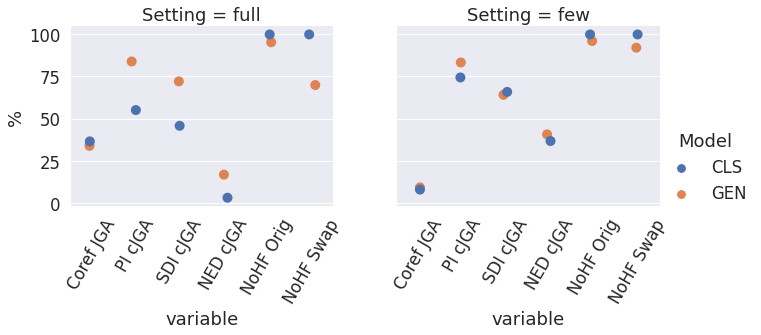

In [113]:
import matplotlib.pyplot as plt 

# sns.set_theme()
sns.set_theme()
sns.set(font_scale = 1.5)
sns.axes_style("darkgrid")
# sns.set_style(fontscale=1.5)
tmp['%'] = tmp['value'].apply(lambda x:x)
g = sns.catplot(x="variable", y="%", hue="Model", col="Setting", data=tmp, kind="strip", height=4, aspect=1.2, s=10, hue_order=["CLS", "GEN"])
g.axes[0][0].set_xticklabels(g.axes[0][0].get_xticklabels(),rotation = 60)
g.axes[0][1].set_xticklabels(g.axes[0][1].get_xticklabels(),rotation = 60)

In [105]:
g.axes[0][0]

<AxesSubplot:title={'center':'Setting = full'}, xlabel='variable', ylabel='value'>

In [106]:
def plot_full_few_comp_chart(cls_df, gen_df): 

    plot_data = pd.concat([cls_df,gen_df], axis=1).set_axis(["CLS", "GEN"], axis=1)
    plot_data = plot_data.reset_index()
    plot_data = plot_data.melt(["index"], ["CLS", "GEN"])

    import seaborn as sns 
    # if values aren't normalized 
    plot_data["value"] = plot_data["value"].apply(lambda x: x*100 if x<1 else x)

    sns.barplot(
        x= "index", y="value", hue="variable", data= plot_data
    )

    return plot_data

In [107]:
plot_full_few_comp_chart(full_cls_df, full_gen_df)
plot_full_few_comp_chart(few_cls_df, few_gen_df)

TypeError: '<' not supported between instances of 'str' and 'int'